
# Step 1: Understand the Dataset
In this section, we will load the XOR dataset used to train and test our Multi-Layer Perceptron (MLP) model. Also , we will import the necessary libraries

## Loading Dataset from a CSV File

The `load_dataset` function reads data from a CSV file and extracts the last three columns as floating-point numbers. It skips the header row and appends each extracted row to a list named `dataset`. The function returns this list, making it useful for loading numerical data for training a machine learning model. This ensures that only relevant columns are used while maintaining data integrity.


In [1]:
import random
import math
import csv
import numpy as np

RANDOM_SEED = 42
random.seed(RANDOM_SEED)


# Load XOR dataset
def load_dataset(filename):
    dataset = []
    with open(filename, "r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            dataset.append(
                [float(row[-3]), float(row[-2]), float(row[-1])]
            )  # Ensure last three columns are used
    return dataset


# Step 2: Preprocessing
Here we define the XOR input and output, which act as our dataset. This step includes preparing inputs and expected outputs.


## Sigmoid Activation Function and Its Derivative

The `sigmoid` function is an activation function used in neural networks. It maps any input \( x \) to a value between 0 and 1, making it useful for binary classification problems. The function is defined as:

The `sigmoid_derivative` function calculates the derivative of the sigmoid function, which is given by:

This derivative is used during backpropagation to update weights in the neural network.

In [2]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)

## Splitting the Dataset into Training and Testing Sets

The `split_dataset` function divides a dataset into training and testing subsets based on a specified `train_ratio`. It first shuffles the dataset randomly to ensure a diverse split. Then, it calculates the number of training samples based on the given ratio (defaulting to 80% for training). The function returns two subsets: one for training and the other for testing, which helps evaluate the model's performance on unseen data.

In [3]:
def split_dataset(dataset, train_ratio=0.8):
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    return dataset[:train_size], dataset[train_size:]

In [4]:
dataset = load_dataset("xor.csv")
train_data, validation_data = split_dataset(dataset)


# Step 3: Define your Neural Network Architecture
Define the MLP architecture and initialization. Different hyperparameters and configurations can be tested for optimal performance.

## Implementation of a Simple Multi-Layer Perceptron (MLP)

This class implements a basic Multi-Layer Perceptron (MLP) with one hidden layer. The MLP is initialized with a specified number of input, hidden, and output nodes. The weights and biases are initialized randomly within a range based on the number of neurons in each layer.  

- **`forward(inputs)`**: Computes the forward pass, applying the sigmoid activation function to both the hidden and output layers.  
- **`backward(inputs, expected_output, learning_rate)`**: Performs backpropagation by calculating errors, computing gradients using the derivative of the sigmoid function, and updating weights and biases.  
- **`train(dataset, epochs, learning_rate, batch_size=2)`**: Trains the model using mini-batch gradient descent, updating weights over multiple epochs and storing the training loss.  
- **`predict(inputs)`**: Uses the trained network to make a binary classification prediction based on the output value.  

This MLP is designed for simple classification tasks and uses Mean Squared Error (MSE) as the loss function. The network updates its parameters using gradient descent.


In [5]:
class MLP:
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
      
        limit_ih = 1 / math.sqrt(input_nodes)
        limit_ho = 1 / math.sqrt(hidden_nodes)
        
        self.weights_input_hidden = [[random.uniform(-limit_ih, limit_ih) for _ in range(hidden_nodes)] for _ in range(input_nodes)]
        self.weights_hidden_output = [random.uniform(-limit_ho, limit_ho) for _ in range(hidden_nodes)]
        self.bias_hidden = [random.uniform(-limit_ih, limit_ih) for _ in range(hidden_nodes)]
        self.bias_output = random.uniform(-limit_ho, limit_ho)
        self.training_loss=[]
        
    def forward(self, inputs):
   
        self.hidden_layer = []
        for i in range(self.hidden_nodes):
            weighted_sum = sum(inputs[j] * self.weights_input_hidden[j][i] for j in range(self.input_nodes)) + self.bias_hidden[i]
            self.hidden_layer.append(sigmoid(weighted_sum))
        output_weighted_sum = sum(self.hidden_layer[i] * self.weights_hidden_output[i] for i in range(self.hidden_nodes)) + self.bias_output
        self.output = sigmoid(output_weighted_sum)
        return self.output
    
    def backward(self, inputs, expected_output, learning_rate):
        output_error = expected_output - self.output
        output_delta = output_error * sigmoid_derivative(self.output)
        hidden_errors = [self.weights_hidden_output[i] * output_delta for i in range(self.hidden_nodes)]
        hidden_deltas = [hidden_errors[i] * sigmoid_derivative(self.hidden_layer[i]) for i in range(self.hidden_nodes)]
        for i in range(self.hidden_nodes):
            self.weights_hidden_output[i] += learning_rate * output_delta * self.hidden_layer[i]
        self.bias_output += learning_rate * output_delta
        for i in range(self.input_nodes):
            for j in range(self.hidden_nodes):
                self.weights_input_hidden[i][j] += learning_rate * hidden_deltas[j] * inputs[i]
        for i in range(self.hidden_nodes):
            self.bias_hidden[i] += learning_rate * hidden_deltas[i]
    
    def train(self, dataset, epochs, learning_rate, batch_size=2):
        for epoch in range(epochs):
            total_error = 0
            random.shuffle(dataset)  
            for i in range(0, len(dataset), batch_size):
                batch = dataset[i:i + batch_size]
                batch_error = 0
                
                for data in batch:
                    inputs = [data[0], data[1]]
                    expected_output = data[2]
                    self.forward(inputs)
                    self.backward(inputs, expected_output, learning_rate)
                    batch_error += (expected_output - self.output) ** 2
                
                total_error += batch_error / batch_size
            self.training_loss.append(total_error)
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Error: {total_error}")
    
    def predict(self, inputs):
        output = self.forward(inputs)
        return 1 if output > 0.5 else 0


## Loss Function
We use Mean Squared Error (MSE) for this binary classification task. Though Cross Entropy is more common for classification, MSE is acceptable for XOR.


# Step 4: Initializing and Training the MLP Model

In this step, an instance of the `MLP` (Multi-Layer Perceptron) class is created with 2 input nodes, 4 hidden nodes, and 1 output node. The model is then trained using the `train` method on the `train_data` dataset for 10,000 epochs with a learning rate of 0.1 and a batch size of 2. During training, the model updates its weights and biases through forward and backward propagation, minimizing the error over time.

In [6]:
mlp = MLP(input_nodes=2, hidden_nodes=8, output_nodes=1)
mlp.train(train_data, epochs=10000, learning_rate=0.1, batch_size=2)

Epoch 0, Error: 101.01645042392634
Epoch 1000, Error: 5.6427064596612215
Epoch 2000, Error: 4.543127127576241
Epoch 3000, Error: 4.000111699613342
Epoch 4000, Error: 3.657464265264206
Epoch 5000, Error: 3.6168821162350233
Epoch 6000, Error: 3.4549831626127836
Epoch 7000, Error: 3.230295183379148
Epoch 8000, Error: 3.1033478690299905
Epoch 9000, Error: 2.7182960269204988



# Step 5: Evaluate Your Model
Evaluate the trained model on the XOR inputs and optionally analyze results using a confusion matrix.

## Evaluating the MLP Model on Validation Data

This code evaluates the trained Multi-Layer Perceptron (MLP) model on a validation dataset. It iterates through the validation data, making predictions using the `predict` method and comparing them to the actual labels. The model's predictions and corresponding actual labels are printed for each data point. It then calculates and displays the overall validation accuracy as a percentage. If no validation data is available, it notifies the user accordingly.

In [7]:
correct_predictions = 0
print("\nValidation Results:")
if len(validation_data) > 0:
    for data in validation_data:
        inputs = [data[0], data[1]]
        prediction = mlp.predict(inputs)
        actual_label = int(data[2])
        print(f"Input: {inputs}, Predicted Label: {prediction}, Actual Label: {actual_label}")
        if prediction == actual_label:
            correct_predictions += 1
    accuracy = (correct_predictions / len(validation_data)) * 100
    print(f"\nValidation Accuracy: {accuracy:.2f}%")
else:
    print("No validation data available.")


Validation Results:
Input: [0.909265459047228, 0.4494478147489037], Predicted Label: 1, Actual Label: 1
Input: [0.21133199607316877, 0.5477760703275425], Predicted Label: 1, Actual Label: 1
Input: [0.40672307570203925, 0.8602713389236996], Predicted Label: 1, Actual Label: 1
Input: [0.007918874456447733, 0.4817555290143672], Predicted Label: 0, Actual Label: 0
Input: [0.6517986038165704, 0.4371820046741696], Predicted Label: 1, Actual Label: 1
Input: [0.19134235993999116, 0.27442640921133543], Predicted Label: 0, Actual Label: 0
Input: [0.5760341888351073, 0.6871444296568735], Predicted Label: 0, Actual Label: 0
Input: [0.7553466258037524, 0.21225570084138362], Predicted Label: 1, Actual Label: 1
Input: [0.7147170950828853, 0.2717533735823953], Predicted Label: 1, Actual Label: 1
Input: [0.642687239155542, 0.21091317831602036], Predicted Label: 1, Actual Label: 1
Input: [0.22263449325114593, 0.8195404305375278], Predicted Label: 1, Actual Label: 1
Input: [0.5221457583691931, 0.1969867

## Model Performance Visualization

This code visualizes the performance of the trained Multi-Layer Perceptron (MLP) model using two key plots: the training loss curve and the confusion matrix. The first plot shows how the training loss decreases over epochs, helping to assess model convergence. The second part of the code computes the confusion matrix by comparing the predicted labels against the true labels from the validation dataset. The matrix is visualized using a heatmap, providing insight into the model’s classification performance by showing correct and incorrect predictions for each class.

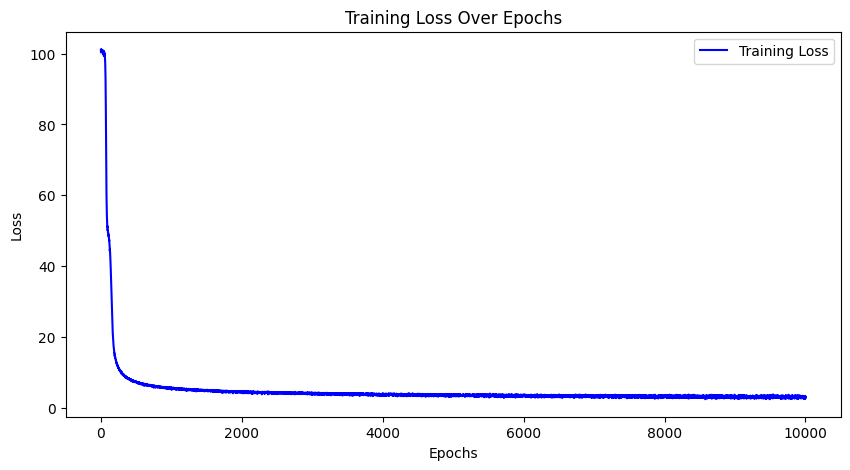

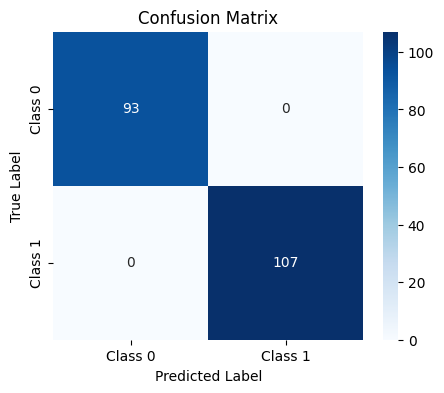

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(mlp.training_loss, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# Confusion Matrix
true_labels = []
predicted_labels = []
for data in validation_data:
    inputs = [data[0], data[1]]
    predicted_labels.append(mlp.predict(inputs))
    true_labels.append(int(data[2]))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()